In [2]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Nombres de las columnas
nombres_columnas = [
    "ID_number", "Diagnosis", "radius", "texture", "perimeter", "area", 
    "smoothness", "compactness", "concavity", "concave_points", "symmetry", 
    "fractal_dimension"
]

caracteristicas = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
nombres_caracteristicas = []

sufijos = ['_mean', '_se', '_worst']
for sufijo in sufijos:
    for caracteristica in caracteristicas:
        nombres_caracteristicas.append(caracteristica + sufijo)

# Unimos los nombres con sufijos a las columnas
nombres_caracteristicas_completos = ["ID_number", "Diagnosis"] + nombres_caracteristicas

# Leemos el archivo y le pasamos los nombres de las columnas
df = pd.read_csv("wdbc.data", names=nombres_caracteristicas_completos)

# Eliminar la columna ID_number ya que no es necesaria para el entrenamiento
df.drop('ID_number', axis=1, inplace=True)

# Refinamos la data para convertir el diagnostico en binario
# Suponiendo que maligno sea 1 y benigno sea 0
label_encoder = LabelEncoder()
df['Diagnosis'] = label_encoder.fit_transform(df['Diagnosis'])


# Separar características y objetivo
datos_tabla = df.drop('Diagnosis', axis=1)
etiquetas_tabla = df['Diagnosis']

# Dividir los datos en conjuntos de entrenamiento y prueba
datos_entrenamiento, datos_prueba, etiquetas_entrenamiento, etiquetas_prueba = train_test_split(datos_tabla, etiquetas_tabla, test_size=0.2, random_state=42)

# Preprocesamiento: Estandarización de las características
caracteristicas_numericas = caracteristicas_numericas = df.columns[2:]
transformador_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputar valores faltantes
    ('scaler', StandardScaler())])  # Estandarizar las características

preprocesador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, caracteristicas_numericas)])

# Definir la funcion para evaluar modelos
def evaluar_modelo(modelo, datos_entrenamiento, etiquetas_entrenamiento, datos_prueba, etiquetas_prueba):
    modelo.fit(datos_entrenamiento, etiquetas_entrenamiento)
    etiquetas_pred = modelo.predict(datos_prueba)
    etiquetas_prob = modelo.predict_proba(datos_prueba)[:, 1] if hasattr(modelo, "predict_proba") else etiquetas_pred
    
    # Calcular metricas para las graficas

    metrics = {
        'Accuracy': accuracy_score(etiquetas_prueba, etiquetas_pred),
        'F1 Score': f1_score(etiquetas_prueba, etiquetas_pred),
        'AUC': roc_auc_score(etiquetas_prueba, etiquetas_prob)
    }
    
    accuracy = metrics["Accuracy"]
    precision = precision_score(etiquetas_prueba, etiquetas_pred)
    recall = recall_score(etiquetas_prueba, etiquetas_pred)
    f1 = metrics["F1 Score"]
    auc = metrics["AUC"]
    
    # Mostrando estadísticas
    print(f"Model: {modelo.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Confusion Matrix:")
    cm = confusion_matrix(etiquetas_prueba, etiquetas_pred)

    # Grafica de matriz de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    
    # Curva ROC
    fpr, tpr, _thresholds = roc_curve(etiquetas_prueba, etiquetas_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {modelo.__class__.__name__}')
    plt.legend(loc="lower right")
    plt.show()

    return metrics



models = [XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
          RandomForestClassifier(n_estimators=100, random_state=42),
          LogisticRegression(max_iter=10000)]

resultados = {}

Model: XGBClassifier
Accuracy: 0.9561
Precision: 0.9524
Recall: 0.9302
F1 Score: 0.9412
AUC: 0.9908
Confusion Matrix:


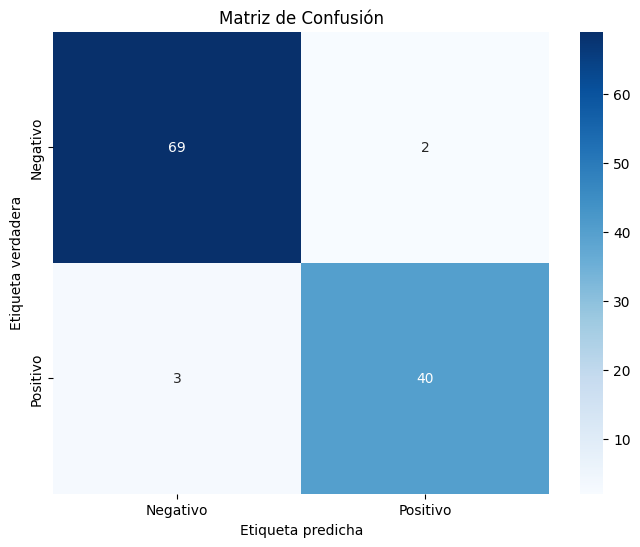

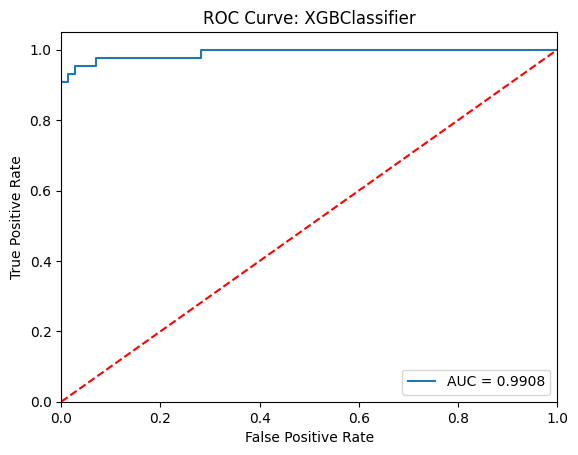

In [3]:
resultados["XGBoost"] = evaluar_modelo(models[0], datos_entrenamiento, etiquetas_entrenamiento, datos_prueba, etiquetas_prueba)

Model: RandomForestClassifier
Accuracy: 0.9649
Precision: 0.9756
Recall: 0.9302
F1 Score: 0.9524
AUC: 0.9953
Confusion Matrix:


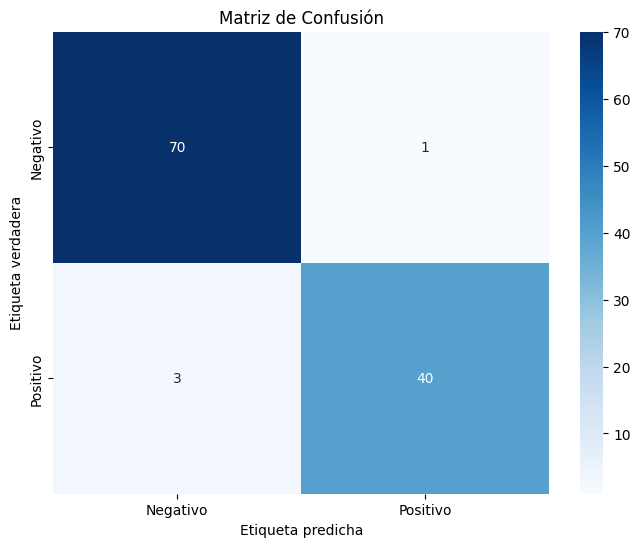

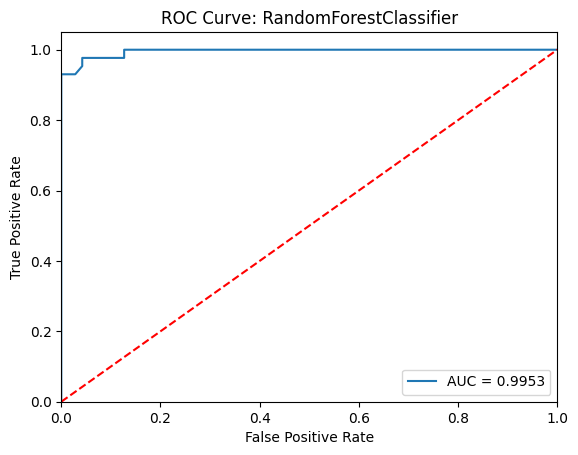

In [4]:
resultados["Random Forest"] = evaluar_modelo(models[1], datos_entrenamiento, etiquetas_entrenamiento, datos_prueba, etiquetas_prueba)

Model: LogisticRegression
Accuracy: 0.9561
Precision: 0.9750
Recall: 0.9070
F1 Score: 0.9398
AUC: 0.9977
Confusion Matrix:


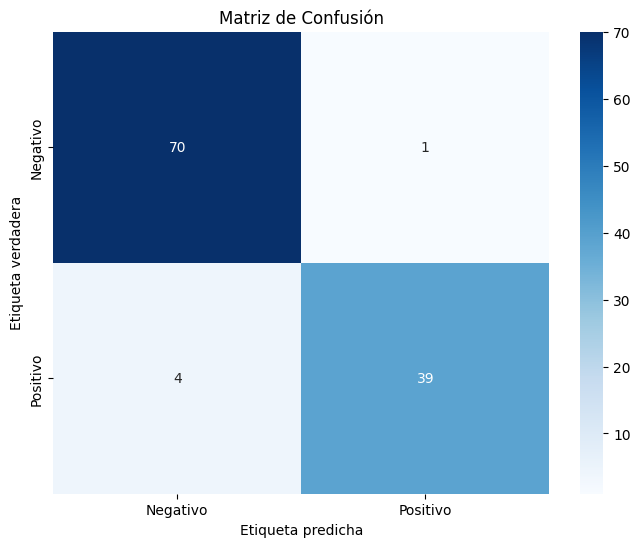

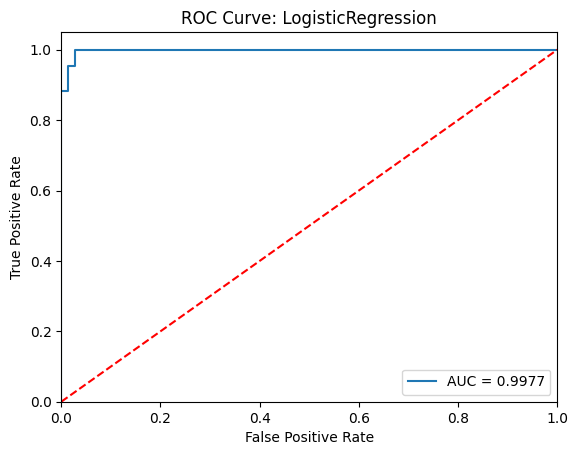

In [5]:
resultados["Logistic Regression"] = evaluar_modelo(models[2], datos_entrenamiento, etiquetas_entrenamiento, datos_prueba, etiquetas_prueba)

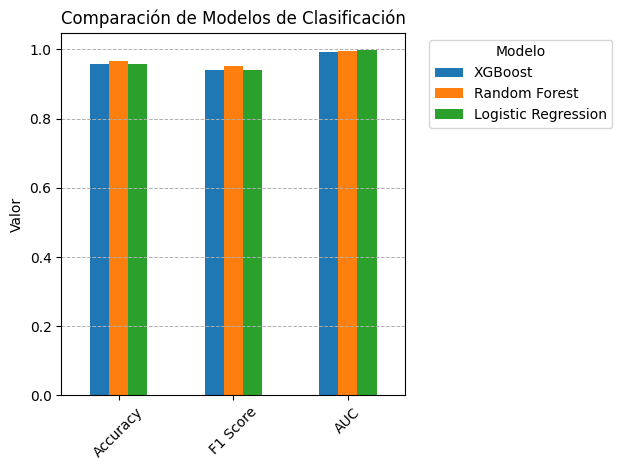

In [6]:
# Convertir resultados a DataFrame para poder graficar
results_df = pd.DataFrame(resultados)

# Crear el gráfico de comparacion
results_df.plot(kind='bar')
plt.title('Comparación de Modelos de Clasificación')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()